<h1> Beta diversity <h1>

<h3> Installing and importing required modules <h3>

In [3]:
#Install
!pip install scikit-bio
!pip install duckdb
!pip install pingouin
!pip install minio
!pip install pandasql
!pip install timeit_decorator

#Import
import io
import math
import os
import re
import warnings

import duckdb
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy
import numpy as np

import pandas as pd
import pingouin as pg
import seaborn as sns
from duckdb import BinderException, CatalogException
from IPython.display import display
from minio import Minio, S3Error
from pandasql import sqldf
from scipy.spatial.distance import pdist, squareform
from scipy.special import entr  # Ensure you import entropy
from scipy.stats import entropy, levene, shapiro
from skbio.stats.distance import DistanceMatrix, permanova
from sklearn.decomposition import PCA
from timeit_decorator import timeit

## Local imports

In [29]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..')))

import numpy as np
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa, pcoa_biplot
from scipy.stats import levene, shapiro, ttest_ind

import momics as mo
from momics.loader import load_parquet_files

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
root_folder = os.path.abspath(os.path.join('../parquet_files'))

### Loading

In [3]:
# parquet files
mgf_parquet_dfs = load_parquet_files(root_folder)

In [4]:
# metadata
sample_metadata = pd.read_csv(
    os.path.join(root_folder, "Batch1and2_combined_logsheets_2024-09-11.csv")
)

# Observatory metadata - from the GoogleSheets
observatory_metadata = pd.read_csv(
    os.path.join(root_folder, "Observatory_combined_logsheets_validated.csv")
)

# This should be pipeline I guess
# merge metadata
full_metadata = pd.merge(
    sample_metadata,
    observatory_metadata,
    on=["obs_id", "env_package"],  # Matching conditions
    how="inner"  # Inner join
)

# Sort the merged dataframe by 'ref_code' column in ascending order
full_metadata = full_metadata.sort_values(by="ref_code", ascending=True)

mgf_parquet_dfs.keys()

In [6]:
mgf_parquet_dfs['SSU'].sort_values(by='abundance', ascending=False)

,ref_code,reads_name,ncbi_tax_id,abundance,superkingdom,kingdom,phylum,class,order,family,genus,species
20456,EMOBON00125,HVWGWDSX5.UDI133,54526,13108.0,Bacteria,None,Proteobacteria,Alphaproteobacteria,Pelagibacterales,None,None,None
18969,EMOBON00124,HVWGWDSX5.UDI121,54526,11329.0,Bacteria,None,Proteobacteria,Alphaproteobacteria,Pelagibacterales,None,None,None
429,EMOBON00141,HCFCYDSX5.UDI124,459520,11043.0,Bacteria,None,Proteobacteria,Gammaproteobacteria,Oceanospirillales,Oceanospirillaceae,Neptuniibacter,None
16722,EMOBON00121,HVWGWDSX5.UDI109,54526,10018.0,Bacteria,None,Proteobacteria,Alphaproteobacteria,Pelagibacterales,None,None,None
14679,EMOBON00120,HVWGWDSX5.UDI097,54526,9851.0,Bacteria,None,Proteobacteria,Alphaproteobacteria,Pelagibacterales,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
31590,EMOBON00001,HWLTKDRXY.UDI235,1525036,1.0,Eukaryota,Metazoa,Platyhelminthes,Rhabditophora,Rhabdocoela,Polycystididae,Limipolycystis,None
31588,EMOBON00001,HWLTKDRXY.UDI235,84076,1.0,Eukaryota,Metazoa,Platyhelminthes,Rhabditophora,Rhabdocoela,Karkinorhynchidae,None,None
31585,EMOBON00001,HWLTKDRXY.UDI235,57453,1.0,Eukaryota,Metazoa,Platyhelminthes,Rhabditophora,Proseriata,Nematoplanidae,Nematoplana,None
31582,EMOBON00001,HWLTKDRXY.UDI235,320143,1.0,Eukaryota,Metazoa,Nematoda,Enoplea,Enoplida,Tripyloididae,None,None


In [7]:
df = mgf_parquet_dfs['SSU'].copy()

In [13]:
df.ref_code.nunique(), df.reads_name.nunique()

(54, 54)

`ref_code` and `reads_name` are the same length so I will use the `ref_code`

### Common methods

In [63]:
def get_missing_taxa(df):
    for taxon in ["superkingdom", "kingdom", "phylum", "class", "order", "family", "genus", "species"]:
        print(f'Not classified on {taxon}: {get_missing_taxa_single(df, taxon)}')
    return

def get_missing_taxa_single(df, taxon):
    return len(df[df[taxon].isnull()])

In [64]:
get_missing_taxa(df)

Not classified on superkingdom: 0
Not classified on kingdom: 28267
Not classified on phylum: 2633
Not classified on class: 5410
Not classified on order: 7471
Not classified on family: 12851
Not classified on genus: 18927
Not classified on species: 29034


## Widget

### methods

In [121]:
def update_beta_diversity(change):
    # Create a pivot table with samples as rows and taxa as columns
    taxon = dropdown_taxon.value
    if taxon == "---":
        return
    
    # if taxon == "ncbi_tax_id":
    df_beta_input = pd.pivot_table(
        df,
        index="ref_code",
        columns=taxon,
        values="abundance",
        fill_value=0,
    )

    # normalize rows
    df_beta_input = df_beta_input.div(df_beta_input.sum(axis=1), axis=0)

    # beta diversity
    beta = beta_diversity("braycurtis", df_beta_input)

    # pcoa
    pcoa_results = pcoa(beta, method='eigh', number_of_dimensions=3)
    # merge metadata with pcoa results
    pcoa_df = pd.merge(
        pcoa_results.samples,
        full_metadata,#[metadata_columns],
        left_index=True,
        right_on="ref_code",
        how="inner",
)

    with output_plot:
        output_plot.clear_output(wait=True)
        print(f'Not classified on {taxon}:')
        miss = get_missing_taxa_single(df, taxon)
        print(miss, f'{np.round(miss/len(df)*100, 2)} %')
        plot_heatmap(beta.to_data_frame())
        plot_pcoa_black(pcoa_df, color_by=pcoa_df['sea_surf_temp'])


# Plot the PCoA with optional coloring
# TODO: color_by does not work for categorical data
def plot_pcoa_black(pcoa_df, color_by=None):
    plt.figure(figsize=(10, 6))

    if color_by is not None:
        scatter = plt.scatter(
            pcoa_df["PC1"], pcoa_df["PC2"], c=color_by, cmap="RdYlGn", edgecolor="k"
        )
        plt.colorbar(scatter, label=color_by.name)
    else:
        plt.scatter(pcoa_df["PC1"], pcoa_df["PC2"], color="black")

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCoA Plot")
    # plt.grid(True)
    plt.show()


def plot_heatmap(df):

    plt.figure(figsize=(10, 6))
    sns.heatmap(df, cmap="viridis")
    plt.title(f"Heatmap of beta diversity")
    plt.show()

In [122]:
dropdown_taxon = widgets.Dropdown(
    options=["---", "ncbi_tax_id", "superkingdom", "kingdom", "phylum", "class", "order", "family", "genus", "species"],  # Options for table selection
    value="---",  # Default selection
    description="Select Taxon for beta diversity calculation:",
)

# dropdown_taxon.observe(update_beta_diversity, names="value")

# Output widget for displaying plots
output_plot = widgets.Output()

/home/davidp/python_projects/marine_omics/momics-demos/momicsdem/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:214: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -0.03969912028376729 whereas the largest positive one is 3.2530958124054843.
  warn(


/home/davidp/python_projects/marine_omics/momics-demos/momicsdem/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:214: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -0.07668033550239685 whereas the largest positive one is 1.8701408888328537.
  warn(


/home/davidp/python_projects/marine_omics/momics-demos/momicsdem/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:214: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -0.03969912028376729 whereas the largest positive one is 3.2530958124054843.
  warn(


### run 

In [123]:
dropdown_taxon.observe(update_beta_diversity, names="value")
display(dropdown_taxon, output_plot)

Dropdown(description='Select Taxon for beta diversity calculation:', options=('---', 'ncbi_tax_id', 'superking…

Output()

### calc beta diversity using `skbio`

In [17]:
# convert DF
# input table is data where each row contains counts of taxa in a given sample
df_beta_input = pd.pivot_table(
    df,
    index="ref_code",
    columns="ncbi_tax_id",
    values="abundance",
    fill_value=0,
)

# normalize rows
df_beta_input = df_beta_input.div(df_beta_input.sum(axis=1), axis=0)

df.ncbi_tax_id.nunique(), df_beta_input.shape

(4311, (54, 4311))

In [18]:
df_beta_input.head()

ncbi_tax_id,2,10,18,20,22,29,39,40,49,53,...,2691357,2691358,2691359,2692249,2692250,2698752,2699527,2699528,2699529,2699530
ref_code,,,,,,,,,,,,,,,,,,,,,
EMOBON00001,0.018025,0.0,0.0,0.0,0.001835,0.009174,0.000000,0.000000,0.000000,0.000108,...,0.016190,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
EMOBON00084,0.014584,0.0,0.0,0.0,0.000000,0.011870,0.000000,0.000000,0.000000,0.000509,...,0.042734,0.0,0.00017,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
EMOBON00086,0.004412,0.0,0.0,0.0,0.057357,0.002622,0.000064,0.000512,0.000000,0.000128,...,0.017584,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000831
EMOBON00088,0.018263,0.0,0.0,0.0,0.000000,0.011306,0.000000,0.000000,0.000000,0.000248,...,0.015903,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
EMOBON00091,0.018235,0.0,0.0,0.0,0.000000,0.007241,0.000000,0.000000,0.000268,0.000134,...,0.022124,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000402


In [21]:
## calculate beta diversity
beta = beta_diversity("braycurtis", df_beta_input)

In [107]:
dir(beta)

['T',
 '__abstractmethods__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_data',
 '_figure_data',
 '_get_mpl_plt',
 '_id_index',
 '_ids',
 '_index_list',
 '_is_id_pair',
 '_matrix_element_name',
 '_repr_png_',
 '_repr_svg_',
 '_stable_order',
 '_subset_to_dataframe',
 '_validate',
 '_validate_ids',
 '_validate_shape',
 'between',
 'condensed_form',
 'copy',
 'data',
 'default_write_format',
 'dtype',
 'filter',
 'from_iterable',
 'ids',
 'index',
 'mpl',
 'permute',
 'plot',
 'plt',
 'png',
 'read',
 'redundant_form',
 'rename',
 'shape',
 'size',
 'svg',
 'to_data_frame',
 'to_series',
 'transpose',
 'within',
 'wri

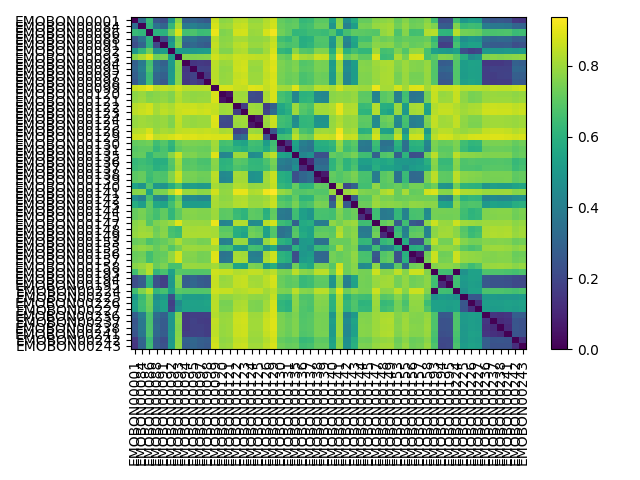

In [24]:
beta

In [77]:
# pcoa
pcoa_results = pcoa(beta, method='eigh', number_of_dimensions=3)


In [78]:
pcoa_results.samples.head()

,PC1,PC2,PC3
EMOBON00001,-0.322500,0.043462,-0.063776
EMOBON00084,-0.294318,0.072053,-0.170594
EMOBON00086,-0.036317,0.161982,-0.106064
EMOBON00088,-0.274890,0.005062,-0.033486
EMOBON00091,-0.310777,0.045746,-0.083913


In [88]:
metadata_columns = [
    "tidal_stage",
    "depth",
    "replicate",
    "ref_code",
    'sea_surf_temp',
    'sea_surf_salinity',
    'alkalinity',
    'ph',
    'latitude',
    'longitude',
    'geo_loc_name',
    "loc_loc",
    'organization',
    "organization_country",
]
for col in metadata_columns:
    print('col', col in full_metadata.columns)
# print(list(full_metadata.columns))

col True
col True
col True
col True
col True
col True
col True
col True
col True
col True
col True
col True
col True
col True


In [94]:
# merge metadata with pcoa results
pcoa_df = pd.merge(
    pcoa_results.samples,
    full_metadata,#[metadata_columns],
    left_index=True,
    right_on="ref_code",
    how="inner",
)

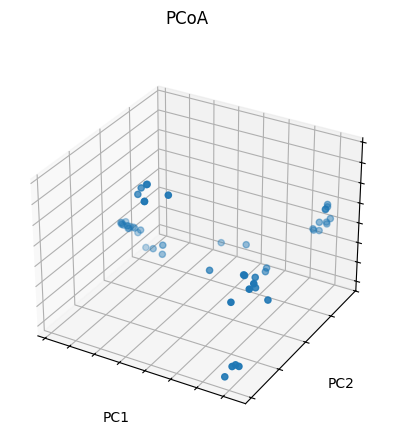

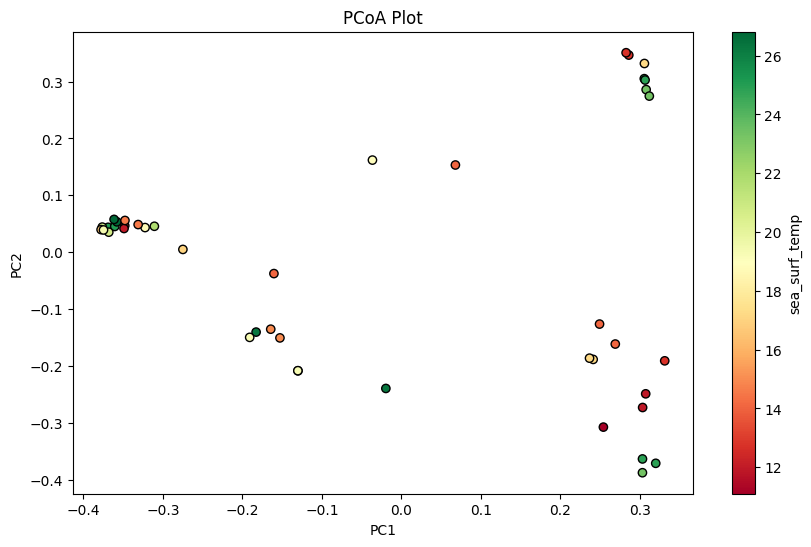

In [95]:
# 3D plot
fig = pcoa_results.plot(axis_labels=("PC1", "PC2", "PC3"))
fig.suptitle("PCoA")
plt.show()

# 2D plot
plot_pcoa_black(pcoa_df, color_by=pcoa_df["sea_surf_temp"])

In [8]:
# Step 1: Filter out rows where 'class' is empty or null
filtered_df = mgf_parquet_dfs["SSU"][
    (mgf_parquet_dfs["SSU"]['class'] != '') & 
    (mgf_parquet_dfs["SSU"]['class'].notnull()),
    ]

# Step 2: Group by 'class' and 'ref_code', then calculate the sum of 'abundance'
grouped_df = filtered_df.groupby(['class', 'ref_code'], as_index=False)['abundance'].sum()

# Step 3: Rename the aggregated column
grouped_df.rename(columns={'abundance': 'total'}, inplace=True)

# Step 4: Pivot the table to spread 'ref_code' across columns
pivoted_df = grouped_df.pivot(index='class', columns='ref_code', values='total')

# Step 5: Fill NaN values with 0 (if required, optional)
pivoted_df.fillna(0, inplace=True)

# Step 6: Reset index and sort by 'class'
result_df = pivoted_df.reset_index().sort_values(by='class')

# Display the result
print(result_df)

InvalidIndexError: (0        False
1        False
2         True
3        False
4        False
         ...  
31594     True
31595     True
31596    False
31597    False
31598     True
Name: class, Length: 31599, dtype: bool,)

<h3> Downloading data from Minio <h3>

In [4]:
client = Minio(
    "10.4.1.4:9000",
    secure=False,
    access_key="PapyfVxlHhHD63nJnB0W",
    secret_key="7Z2q9uD44CS2HEBGhbvJi0nhLcvjgffZwG9wqJ1j",
)

# The destination bucket and filename on the MinIO server
bucket_name = "emo-bon-tables"

objects = client.list_objects(bucket_name, recursive=True)
objs = []
for i, obj in enumerate(objects):
    objs.append(obj.object_name)
    print(f"Print index {i} has object {obj.object_name}")

table_name = objs[1]
try:
    response = client.get_object(bucket_name, table_name)
    buffer = io.BytesIO(response.read())
except S3Error:
    raise
finally:
    df = pd.read_parquet(buffer, engine="pyarrow")
    response.close()
    response.release_conn()
df.info()
print(f"Downloaded {table_name} into df dataframe")

MaxRetryError: HTTPConnectionPool(host='10.4.1.4', port=9000): Max retries exceeded with url: /emo-bon-tables?location= (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x7f27cfb5b700>, 'Connection to 10.4.1.4 timed out. (connect timeout=300)'))

<h3> Here the user should be able to select a table (change the code below) <h3>

In [ ]:
try:
    duckdb.sql("DROP TABLE SSU")
except CatalogException:
    pass
duckdb.sql("CREATE TABLE SSU AS SELECT * FROM df")
duckdb.sql("SELECT COUNT(*) FROM SSU")

# Query to get column names from the 'SSU' table
column_headers = duckdb.sql(
    "SELECT column_name FROM information_schema.columns WHERE table_name = 'SSU';"
).fetchdf()

# Print the column headers
print(column_headers["column_name"].tolist())

In [ ]:
def get_object(bucket_name, file_format, file_name, verbose=True):
    if verbose:
        print(f"{bucket_name=} - {file_format=} - {file_name=}")
    try:
        response = client.get_object(bucket_name, file_name)
        buffer = io.BytesIO(response.read())
    except S3Error:
        raise
    finally:
        if file_format == "parquet":
            df = pd.read_parquet(buffer, engine="pyarrow")
        elif file_format == "csv":
            df = pd.read_csv(buffer)
        else:
            raise ValueError(f"Unknown {file_format=}")
        response.close()
        response.release_conn()
        if verbose:
            print(f"Downloaded {file_name} into dataframe")
    return df

In [ ]:
# The destination bucket and filename on the MinIO server
#bucket_name = "emo-bon-tables"
#for obj in client.list_objects(bucket_name):
#    print(obj.object_name)
# Currently only v1 tables are available

<h3> Working on full metadata <h3>

In [ ]:
# MGF parquet tables to data frames
bucket_name = "emo-bon-tables"
objects = client.list_objects(bucket_name, recursive=True)
mgf_parquet_dfs = {}
for obj in objects:
    name = obj.object_name.split(".")[-2]
    df = get_object(bucket_name, "parquet", obj.object_name, verbose=False)
    mgf_parquet_dfs[name] = df

# Sample metadata
# Get the latest Batch combined logsheets file
# Remember we are downloading from MinIO
batch_file = "Batch1and2_combined_logsheets_2024-09-11.csv"
sample_metadata = ("emo-bon-metadata-tables", "csv", batch_file)
sample_metadata = get_object(*sample_metadata, verbose=False)

# Observatory metadata - from the GoogleSheets
observatory_metadata = (
    "emo-bon-metadata-tables",
    "csv",
    "Observatory_combined_logsheets_validated.csv",
)
observatory_metadata = get_object(*observatory_metadata, verbose=False)

# Into duckdb
try:
    duckdb.sql("DROP TABLE SAMPLE_METADATA")
    duckdb.sql("DROP TABLE OBS_METADATA")
    for table_name in mgf_parquet_dfs:
        cmd = f"DROP TABLE {table_name}"
        duckdb.sql(cmd)
except CatalogException:
    pass
duckdb.sql("CREATE TABLE SAMPLE_METADATA AS SELECT * FROM sample_metadata")
duckdb.sql("SELECT COUNT(*) FROM SAMPLE_METADATA")
duckdb.sql("CREATE TABLE OBS_METADATA AS SELECT * FROM observatory_metadata")
duckdb.sql("SELECT COUNT(*) FROM OBS_METADATA")
for table_name in mgf_parquet_dfs:
    df = mgf_parquet_dfs[table_name]
    cmd = f"CREATE TABLE {table_name} AS SELECT * FROM df"
    duckdb.sql(cmd)

duckdb.sql("SHOW TABLES")

In [ ]:
duckdb.sql("SHOW TABLES")

<h3> Define the query <h3>

In [ ]:
query = """
PIVOT (
SELECT
ref_code,
class,
sum(abundance) as total
FROM SSU 
WHERE class <> '' AND class IS NOT NULL
GROUP BY class, ref_code
ORDER BY class, sum(abundance) DESC
)
ON ref_code
USING sum(total)
ORDER BY class
"""

# Save the result of the query into a DuckDB table called "SSU_class_all"
duckdb.sql(
    f"""
CREATE TABLE SSU_class_all AS
{query}
"""
)

# Optionally, show the saved table to verify it
duckdb.sql("SELECT * FROM SSU_class_all").show(max_width=30, max_rows=55)

In [ ]:
#### joining all the tables together - metadata and the SSU class level
### NaN converted to 0, but the data needs standardisation and square rooting

# Define the query for full_metadata
query = """
SELECT OBS_METADATA.*,
       SAMPLE_METADATA.*,
FROM SAMPLE_METADATA
INNER JOIN OBS_METADATA 
ON SAMPLE_METADATA.obs_id = OBS_METADATA.obs_id
AND SAMPLE_METADATA.env_package = OBS_METADATA.env_package
ORDER BY SAMPLE_METADATA.ref_code ASC
"""

# Get the full_metadata DataFrame
full_metadata = duckdb.sql(query).df()

# Define the query to get SSU_class_all data
ssu_class_all_query = "SELECT * FROM SSU_class_all"

# Get the SSU_class_all DataFrame
ssu_class_all = duckdb.sql(ssu_class_all_query).df()

# Step 1: Transpose the 'SSU_class_all' DataFrame
ssu_class_all_transposed = ssu_class_all.transpose().reset_index()
ssu_class_all_transposed.columns = ["ref_code"] + list(
    ssu_class_all_transposed.iloc[0, 1:]
)  # Set ref_code as the first column and the remaining as data
ssu_class_all_transposed = ssu_class_all_transposed.drop(0).reset_index(
    drop=True
)  # Drop the first row used for column names

# Step 2: Convert NaN values in the transposed 'SSU_class_all' to 0
ssu_class_all_transposed = ssu_class_all_transposed.fillna(0)

# Step 3: Add prefix to each column header from SSU_class_all
ssu_class_all_transposed.columns = ["ref_code"] + [
    "class_" + col for col in ssu_class_all_transposed.columns[1:]
]

# Step 4: Merge the transposed 'SSU_class_all' with 'full_metadata' on 'ref_code'
merged_data = pd.merge(
    full_metadata, ssu_class_all_transposed, on="ref_code", how="inner"
)

# Step 5: Reorder columns to place SSU_class_all columns at the beginning
ssu_class_all_columns = [
    col for col in ssu_class_all_transposed.columns if col != "ref_code"
]
other_columns = [
    col
    for col in merged_data.columns
    if col not in ssu_class_all_columns and col != "ref_code"
]

# Define new column order: SSU_class_all columns first, then other columns, followed by 'ref_code'
new_column_order = ssu_class_all_columns + other_columns + ["ref_code"]
merged_data = merged_data[new_column_order]

# Display the reordered merged data (optional)
print(merged_data)

# Export the result to CSV
output_csv = "merged_data.csv"  # Specify your file path here

duckdb.sql(
    f"""
COPY (
    {query}
) TO '{output_csv}' WITH (FORMAT CSV, HEADER TRUE)
"""
)

In [ ]:
# Execute the query to get SSU_class_all
ssu_class_all_query = "SELECT * FROM SSU_class_all"

# Get the SSU_class_all DataFrame
ssu_class_all = duckdb.sql(ssu_class_all_query).df()

# Option 1: Print the full DataFrame
print(ssu_class_all)

In [ ]:
# Define the function to calculate Shannon index


def calculate_shannon_index(df):
    def shannon_index(row):
        total_abundance = row.sum()
        if total_abundance == 0:
            return np.nan
        relative_abundance = row / total_abundance
        return entropy(
            relative_abundance, base=np.e
        )  # Shannon entropy (natural log base)

    return df.apply(shannon_index, axis=1)


# Extract numeric columns and metadata
numeric_columns = [col for col in merged_data.columns if col.startswith("class_")]
metadata_columns = [
    col
    for col in merged_data.columns
    if not col.startswith("class_") and col != "ref_code"
]

# Convert columns to numeric and replace NaN with 0
merged_data[numeric_columns] = (
    merged_data[numeric_columns].apply(pd.to_numeric, errors="coerce").fillna(0)
)

# Calculate Shannon index for each sample
shannon_values = calculate_shannon_index(merged_data[numeric_columns])

# Create a DataFrame for Shannon index values
shannon_df = pd.DataFrame(
    {"ref_code": merged_data["ref_code"], "Shannon": shannon_values}
)

# Plot the Shannon index for each sample
plt.figure(figsize=(12, 6))
plt.bar(shannon_df["ref_code"], shannon_df["Shannon"], color="skyblue")
plt.xlabel("Sample")
plt.ylabel("Shannon Index")
plt.title("Shannon Index for Each Sample")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
numeric_columns = [col for col in merged_data.columns if col.startswith("class_")]
metadata_columns = [
    col
    for col in merged_data.columns
    if not col.startswith("class_") and col != "ref_code"
]

# Convert columns to numeric and replace NaN with 0
merged_data[numeric_columns] = (
    merged_data[numeric_columns].apply(pd.to_numeric, errors="coerce").fillna(0)
)

# Calculate Shannon index for each sample
shannon_values = calculate_shannon_index(merged_data[numeric_columns])


# Example if metadata is a list of dictionaries
metadata = pd.DataFrame(metadata)


# Function to calculate Shannon index
def calculate_shannon_index(df):
    def shannon_index(row):
        total_abundance = row.sum()
        if total_abundance == 0:
            return np.nan
        relative_abundance = row / total_abundance
        return entr(relative_abundance).sum()  # Shannon entropy

    return df.apply(shannon_index, axis=1)


def calculate_alpha_diversity(df, metadata):
    # Filter numeric columns for Shannon calculation
    numeric_columns = [col for col in df.columns if col.startswith("class_")]
    transposed_data = df[numeric_columns].copy()  # Select only numeric columns
    shannon_values = calculate_shannon_index(transposed_data)
    alpha_diversity_df = pd.DataFrame(
        {"ref_code": df["ref_code"], "Shannon": shannon_values}
    )
    alpha_diversity_df = pd.merge(
        alpha_diversity_df, metadata, on="ref_code", how="left"
    )
    return alpha_diversity_df


def plot_shannon_index(alpha_diversity_df, selected_factor):
    alpha_diversity_sorted = alpha_diversity_df.sort_values(by=selected_factor)
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x="ref_code",
        y="Shannon",
        hue=selected_factor,
        data=alpha_diversity_sorted,
        dodge=False,
        palette="coolwarm",
        errorbar=None,
    )
    plt.xlabel("Sample")
    plt.ylabel("Shannon Index")
    plt.title(f"Shannon Index Grouped by {selected_factor}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


def plot_average_shannon_per_condition(alpha_diversity_df, selected_factor):
    palette = sns.color_palette(
        "coolwarm", len(alpha_diversity_df[selected_factor].unique())
    )
    grouped_data = alpha_diversity_df.groupby(selected_factor)["Shannon"]
    means = grouped_data.mean()
    errors = grouped_data.sem()
    plt.figure(figsize=(10, 6))
    means.plot(kind="bar", yerr=errors, color=palette, capsize=5)
    plt.xlabel(selected_factor)
    plt.ylabel("Average Shannon Index")
    plt.title(f"Average Shannon Index by {selected_factor}")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def check_normality(data):
    """Check normality using Shapiro-Wilk test"""
    stat, p_value = shapiro(data)
    return p_value > 0.05  # True if data is normally distributed


def check_homogeneity_of_variances(groups):
    """Check homogeneity of variances using Levene's test"""
    stat, p_value = levene(*groups)
    return p_value > 0.05  # True if variances are equal


def run_anova_and_posthoc(alpha_diversity_df, selected_factor):
    # ANOVA for the selected factor
    anova_results = pg.anova(
        data=alpha_diversity_df, dv="Shannon", between=selected_factor
    )

    # Create a string to capture the output
    anova_output = "\nANOVA Results:\n"
    anova_output += anova_results.to_string(index=False)

    # Check the distribution of data
    grouped_data = alpha_diversity_df.groupby(selected_factor)["Shannon"]
    groups = [group for name, group in grouped_data]

    normal = check_normality(alpha_diversity_df["Shannon"])
    homogeneity = check_homogeneity_of_variances(groups)

    normality_result = f"Normality check: {'Pass' if normal else 'Fail'}"
    homogeneity_result = (
        f"Homogeneity of variances check: {'Pass' if homogeneity else 'Fail'}"
    )

    anova_output += f"\n{normality_result}\n{homogeneity_result}"

    if anova_results["p-unc"].values[0] < 0.05:
        posthoc_results_str = ""
        if normal and homogeneity:
            # Tukey's HSD for normal data and equal variances
            posthoc_results = pg.pairwise_ttests(
                data=alpha_diversity_df,
                dv="Shannon",
                between=selected_factor,
                padjust="holm",
            )
            posthoc_results_str = "\nPost-hoc test used: Tukey's HSD\n"
            posthoc_results_str += posthoc_results.to_string(index=False)
        else:
            # Games-Howell for non-normal data or unequal variances
            posthoc_results = pg.pairwise_gameshowell(
                data=alpha_diversity_df, dv="Shannon", between=selected_factor
            )
            posthoc_results_str = "\nPost-hoc test used: Games-Howell\n"
            posthoc_results_str += posthoc_results.to_string(index=False)

        anova_output += f"\n\n{posthoc_results_str}"
    else:
        anova_output += f"\nNo significant difference found in {selected_factor}. Post-hoc test is not necessary."

    return anova_output


def update_plot(change):
    with output_plot:
        output_plot.clear_output(wait=True)
        selected_factor = color_factor_dropdown.value
        alpha_diversity_df = calculate_alpha_diversity(
            data, metadata
        )  # Ensure 'data' and 'metadata' are defined
        plot_shannon_index(alpha_diversity_df, selected_factor)
        plot_average_shannon_per_condition(alpha_diversity_df, selected_factor)

        # Run ANOVA and display results
        anova_output = run_anova_and_posthoc(alpha_diversity_df, selected_factor)
        print(anova_output)  # Print ANOVA results to the output area


# Ensure metadata is a DataFrame and contains valid columns
if isinstance(metadata, pd.DataFrame):
    options = [
        col
        for col in metadata.columns
        if not col.startswith("class_") and col != "ref_code"
    ]
else:
    print("metadata is not a DataFrame. Please check the definition.")
    options = []

# Widget Definition for Color Factor
color_factor_dropdown = widgets.Dropdown(
    options=options,
    description="Color Factor:",
)
# Output area for plots
output_plot = widgets.Output()

# Link the dropdown to the update function
color_factor_dropdown.observe(update_plot, names="value")

# Display widgets
display(color_factor_dropdown, output_plot)

In [ ]:
print(metadata.columns)

In [ ]:
# Assuming merged_data is a DataFrame already defined
numeric_columns = [col for col in merged_data.columns if col.startswith("class_")]
metadata_columns = [
    col
    for col in merged_data.columns
    if not col.startswith("class_") and col != "ref_code"
]

# Convert columns to numeric and replace NaN with 0
merged_data[numeric_columns] = (
    merged_data[numeric_columns].apply(pd.to_numeric, errors="coerce").fillna(0)
)


# Calculate Shannon index for each sample
def calculate_shannon_index(df):
    def shannon_index(row):
        total_abundance = row.sum()
        if total_abundance == 0:
            return np.nan
        relative_abundance = row / total_abundance
        return entr(relative_abundance).sum()  # Shannon entropy

    return df.apply(shannon_index, axis=1)


shannon_values = calculate_shannon_index(merged_data[numeric_columns])

# Ensure metadata is a DataFrame
metadata = pd.DataFrame(metadata) if isinstance(metadata, (list, dict)) else metadata


def calculate_alpha_diversity(df, metadata):
    numeric_columns = [col for col in df.columns if col.startswith("class_")]
    transposed_data = df[numeric_columns].copy()
    shannon_values = calculate_shannon_index(transposed_data)
    alpha_diversity_df = pd.DataFrame(
        {"ref_code": df["ref_code"], "Shannon": shannon_values}
    )
    alpha_diversity_df = pd.merge(
        alpha_diversity_df, metadata, on="ref_code", how="left"
    )
    return alpha_diversity_df


def plot_shannon_index(alpha_diversity_df, selected_factor):
    alpha_diversity_sorted = alpha_diversity_df.sort_values(by=selected_factor)
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x="ref_code",
        y="Shannon",
        hue=selected_factor,
        data=alpha_diversity_sorted,
        dodge=False,
        palette="coolwarm",
        errorbar=None,
    )
    plt.xlabel("Sample")
    plt.ylabel("Shannon Index")
    plt.title(f"Shannon Index Grouped by {selected_factor}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


def plot_average_shannon_per_condition(alpha_diversity_df, selected_factor):
    palette = sns.color_palette(
        "coolwarm", len(alpha_diversity_df[selected_factor].unique())
    )
    grouped_data = alpha_diversity_df.groupby(selected_factor)["Shannon"]
    means = grouped_data.mean()
    errors = grouped_data.sem()
    plt.figure(figsize=(10, 6))
    means.plot(kind="bar", yerr=errors, color=palette, capsize=5)
    plt.xlabel(selected_factor)
    plt.ylabel("Average Shannon Index")
    plt.title(f"Average Shannon Index by {selected_factor}")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def check_normality(data):
    """Check normality using Shapiro-Wilk test"""
    stat, p_value = shapiro(data)
    return p_value > 0.05  # True if data is normally distributed


def check_homogeneity_of_variances(groups):
    """Check homogeneity of variances using Levene's test"""
    stat, p_value = levene(*groups)
    return p_value > 0.05  # True if variances are equal


def run_anova_and_posthoc(alpha_diversity_df, selected_factor):
    # ANOVA for the selected factor
    anova_results = pg.anova(
        data=alpha_diversity_df, dv="Shannon", between=selected_factor
    )

    # Create a string to capture the output
    anova_output = "\nANOVA Results:\n"
    anova_output += anova_results.to_string(index=False)

    # Check the distribution of data
    grouped_data = alpha_diversity_df.groupby(selected_factor)["Shannon"]
    groups = [group for name, group in grouped_data]

    normal = check_normality(alpha_diversity_df["Shannon"])
    homogeneity = check_homogeneity_of_variances(groups)

    normality_result = f"Normality check: {'Pass' if normal else 'Fail'}"
    homogeneity_result = (
        f"Homogeneity of variances check: {'Pass' if homogeneity else 'Fail'}"
    )

    anova_output += f"\n{normality_result}\n{homogeneity_result}"

    if anova_results["p-unc"].values[0] < 0.05:
        posthoc_results_str = ""
        if normal and homogeneity:
            # Tukey's HSD for normal data and equal variances
            posthoc_results = pg.pairwise_ttests(
                data=alpha_diversity_df,
                dv="Shannon",
                between=selected_factor,
                padjust="holm",
            )
            posthoc_results_str = "\nPost-hoc test used: Tukey's HSD\n"
            posthoc_results_str += posthoc_results.to_string(index=False)
        else:
            # Games-Howell for non-normal data or unequal variances
            posthoc_results = pg.pairwise_gameshowell(
                data=alpha_diversity_df, dv="Shannon", between=selected_factor
            )
            posthoc_results_str = "\nPost-hoc test used: Games-Howell\n"
            posthoc_results_str += posthoc_results.to_string(index=False)

        anova_output += f"\n\n{posthoc_results_str}"
    else:
        anova_output += f"\nNo significant difference found in {selected_factor}. Post-hoc test is not necessary."

    return anova_output


def update_plot(change):
    with output_plot:
        output_plot.clear_output(wait=True)
        selected_factor = color_factor_dropdown.value
        alpha_diversity_df = calculate_alpha_diversity(
            merged_data, metadata
        )  # Ensure 'merged_data' and 'metadata' are defined
        plot_shannon_index(alpha_diversity_df, selected_factor)
        plot_average_shannon_per_condition(alpha_diversity_df, selected_factor)

        # Run ANOVA and display results
        anova_output = run_anova_and_posthoc(alpha_diversity_df, selected_factor)
        print(anova_output)  # Print ANOVA results to the output area


# Ensure metadata is a DataFrame
if isinstance(metadata, pd.DataFrame):
    color_factor_dropdown = widgets.Dropdown(
        options=[
            col
            for col in metadata.columns
            if not col.startswith("class_") and col != "ref_code"
        ],
        description="Color Factor:",
    )
else:
    print("Error: metadata is not a DataFrame.")
    # Handle the error or initialize metadata properly

# Output area for plots
output_plot = widgets.Output()

# Link the dropdown to the update function
color_factor_dropdown.observe(update_plot, names="value")

# Display widgets
display(color_factor_dropdown, output_plot)

In [ ]:
### delete later

# Step 1: Load the table from DuckDB into a DataFrame
data = duckdb.sql("SELECT * FROM SSU_for_visualisation").fetchdf()

# Step 2: Set 'taxonomic_concat' as the index and transpose the DataFrame
transposed_data = data.set_index("taxonomic_concat").T

# Step 3: Load the material information from the CSV file
metadata = pd.read_csv("/home/jupyter-andrzej/metadata/metadata_jup_test4.csv")

# Step 4: Merge metadata with transposed data based on 'ref_code'
merged_data = pd.merge(
    transposed_data,
    metadata[
        ["ref_code"]
        + [
            col
            for col in metadata.columns
            if col not in ["ref_code", "our_code", "#NAME"]
        ]
    ],
    left_index=True,
    right_on="ref_code",
)

# Exclude metadata columns from Shannon index calculation
metadata_columns = [
    "filter_size",
    "date",
    "replcate",
    "station_filter",
    "filter_rep",
    "location",
    "country",
    "column12",
    "column13",
]
numeric_columns = [
    col for col in transposed_data.columns if col not in metadata_columns
]


#############################
# Step 1: Load the table from DuckDB into a DataFrame
data = merged_data  # Use 'merged_data'

# Ensure that we only use numeric data for distance calculation
numeric_columns = [
    col for col in data.columns if col.startswith("class_")
]  # Columns with the prefix 'class_'
metadata = [
    col for col in data.columns if not col.startswith("class_") and col != "ref_code"
]

# Convert the columns to numeric (if they are not already) and replace NaN with 0
data[numeric_columns] = (
    data[numeric_columns].apply(pd.to_numeric, errors="coerce").fillna(0)
)
# data[numeric_columns] = data[numeric_columns].astype(float).fillna(0)


# Now all 'NaN' values in columns with names starting with 'class_' have been replaced with 0.


############################


# Function to calculate Shannon index
# def calculate_shannon_index(df):
#    def shannon_index(row):
#        float_values = row
#        if float_values.sum() == 0:
#            return np.nan
#        relative_abundance = float_values / float_values.sum()
#        return entropy(relative_abundance, base=np.e)

#    return df.apply(shannon_index, axis=1)

# Filter columns matching the pattern 'number;sk_*' (where 'number;' can be any text)
# pattern = re.compile(r'^.*;sk_.*')
# filtered_data = merged_data.filter(regex=pattern)

# Calculate Shannon index and add it as a new column
# merged_data['Shannon'] = calculate_shannon_index(filtered_data)

# Function to plot alpha diversity metrics


def plot_alpha_diversity_grouped(alpha_diversity_df, selected_factor):
    alpha_diversity_sorted = alpha_diversity_df.sort_values(by=selected_factor)
    plt.figure(figsize=(12, 6))

    # Suppress FutureWarnings related to the ci parameter
    with warnings.catch_warnings():
        warnings.simplefilter(action="ignore", category=FutureWarning)
        sns.barplot(
            x="ref_code",
            y="Shannon",
            hue=selected_factor,
            data=alpha_diversity_sorted,
            dodge=False,
            palette="coolwarm",
            errorbar=None,
        )

    plt.xlabel("Sample")
    plt.ylabel("Shannon Index")
    plt.title(f"Shannon Index Grouped by {selected_factor}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


# Calculate alpha diversity metrics (Shannon)


from scipy.stats import entropy


def calculate_shannon_index(df):
    def shannon_index(row):
        total_abundance = row.sum()
        if total_abundance == 0:
            return np.nan
        relative_abundance = row / total_abundance
        return entropy(
            relative_abundance, base=np.e
        )  # Shannon entropy (natural log base)

    return df.apply(shannon_index, axis=1)


def calculate_alpha_diversity(transposed_data, metadata):
    # Calculate Shannon index for each sample
    shannon_values = calculate_shannon_index(transposed_data)

    # Create a DataFrame for Shannon index values
    alpha_diversity_df = pd.DataFrame(
        {"ref_code": transposed_data.index, "Shannon": shannon_values}
    )

    # Merge the Shannon index with metadata
    alpha_diversity_df = pd.merge(
        alpha_diversity_df, metadata, on="ref_code", how="left"
    )

    return alpha_diversity_df


# Function to calculate ANOVA for all factors and run post-hoc test for the selected factor
def run_anova_for_factors(alpha_diversity_df, selected_factor):
    # List of all factors from the metadata (excluding ref_code and other irrelevant columns)
    all_factors = [
        col
        for col in metadata.columns
        if not re.search(r"\d", col) and col not in ["ref_code", "our_code", "#NAME"]
    ]

    print("\nANOVA Results for all Factors:")
    anova_results_list = []
    for factor in all_factors:
        anova_results = pg.anova(data=alpha_diversity_df, dv="Shannon", between=factor)
        f_value = anova_results["F"].values[0]
        p_value = anova_results["p-unc"].values[0]
        anova_results_list.append((factor, f_value, p_value))
        print(f"{factor} - F-value: {f_value:.4f}, p-value: {p_value:.4f}")

    # Based on the selected factor, run the post-hoc test if p-value < 0.05
    selected_factor_anova = [
        result for result in anova_results_list if result[0] == selected_factor
    ][0]

    if selected_factor_anova[2] < 0.05:
        print(f"\nRunning post-hoc tests for {selected_factor}...")
        posthoc_results = pg.pairwise_ttests(
            data=alpha_diversity_df, dv="Shannon", between=selected_factor
        )
        print("\nPosthoc Test Results:")
        print(posthoc_results)
    else:
        print(
            f"No significant difference found in {selected_factor}. Post-hoc test is not necessary."
        )


def check_normality(data):
    """Check normality using Shapiro-Wilk test"""
    stat, p_value = shapiro(data)
    return p_value > 0.05  # True if data is normally distributed


def check_homogeneity_of_variances(groups):
    """Check homogeneity of variances using Levene's test"""
    stat, p_value = levene(*groups)
    return p_value > 0.05  # True if variances are equal


def run_anova_and_posthoc(alpha_diversity_df, selected_factor):
    # ANOVA for the selected factor
    anova_results = pg.anova(
        data=alpha_diversity_df, dv="Shannon", between=selected_factor
    )
    print("\nANOVA Results:")
    print(anova_results)

    # Check the distribution of data
    grouped_data = alpha_diversity_df.groupby(selected_factor)["Shannon"]
    groups = [group for name, group in grouped_data]

    normal = check_normality(alpha_diversity_df["Shannon"])
    homogeneity = check_homogeneity_of_variances(groups)

    print(f"Normality check: {'Pass' if normal else 'Fail'}")
    print(f"Homogeneity of variances check: {'Pass' if homogeneity else 'Fail'}")

    if anova_results["p-unc"].values[0] < 0.05:
        print(f"\nRunning post-hoc tests for {selected_factor}...")

        if normal and homogeneity:
            # Tukey's HSD for normal data and equal variances
            posthoc_results = pg.pairwise_ttests(
                data=alpha_diversity_df,
                dv="Shannon",
                between=selected_factor,
                padjust="holm",
            )
            print("Post-hoc test used: Tukey's HSD")
        else:
            # Games-Howell for non-normal data or unequal variances
            posthoc_results = pg.pairwise_gameshowell(
                data=alpha_diversity_df, dv="Shannon", between=selected_factor
            )
            print("Post-hoc test used: Games-Howell")

        print("\nPosthoc Test Results:")
        print(posthoc_results)
    else:
        print(
            f"No significant difference found in {selected_factor}. Post-hoc test is not necessary."
        )


# Use the function in the update_alpha_diversity
def update_alpha_diversity(change):
    with output_alpha_diversity:
        output_alpha_diversity.clear_output(wait=True)

        selected_factor = alpha_factor_dropdown.value

        # Calculate alpha diversity with metadata
        alpha_diversity_df = calculate_alpha_diversity(transposed_data, metadata)

        # Plot the alpha diversity grouped by the selected factor
        plot_alpha_diversity_grouped(alpha_diversity_df, selected_factor)

        # Plot the average Shannon index per category
        plot_average_shannon(alpha_diversity_df, selected_factor)

        # Run ANOVA and post-hoc tests with appropriate test selection
        run_anova_and_posthoc(alpha_diversity_df, selected_factor)


# Widget Definition for Grouping Factor (only)
alpha_factor_dropdown = widgets.Dropdown(
    options=[
        col
        for col in metadata.columns
        if not re.search(r"\d", col) and col not in ["ref_code", "our_code", "#NAME"]
    ],
    description="Grouping Factor:",
)


def plot_average_shannon(alpha_diversity_df, selected_factor):
    # Determine the color palette from the grouped plot
    palette = sns.color_palette(
        "coolwarm", len(alpha_diversity_df[selected_factor].unique())
    )

    # Group data by the selected factor and calculate the mean and standard error of Shannon index
    grouped_data = alpha_diversity_df.groupby(selected_factor)["Shannon"]
    means = grouped_data.mean()
    errors = grouped_data.sem()  # Standard error of the mean

    plt.figure(figsize=(8, 6))

    # Plot the average Shannon index with error bars and custom colors
    bars = means.plot(kind="bar", yerr=errors, color=palette, capsize=5)
    plt.xlabel(selected_factor)
    plt.ylabel("Average Shannon Index")
    plt.title(f"Average Shannon Index by {selected_factor}")
    plt.xticks(rotation=90)
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Output area for Alpha Diversity
output_alpha_diversity = widgets.Output()

# Link alpha diversity dropdowns to the update function
alpha_factor_dropdown.observe(update_alpha_diversity, names="value")

# Display widgets
display(alpha_factor_dropdown, output_alpha_diversity)

In [ ]:
# print(merged_data)

In [ ]:
# Assuming `merged` is the updated DataFrame
data = merged_data  # Use 'merged' instead of 'SSU_class_all'

# Set 'ref_code' as the index and transpose the DataFrame
transposed_data = data.set_index("ref_code").T

# Load metadata from `merged`
metadata = full_metadata

# Exclude metadata columns from Shannon index calculation
metadata_columns = [
    "filter_size",
    "date",
    "replcate",
    "station_filter",
    "filter_rep",
    "location",
    "country",
    "column12",
    "column13",
]
numeric_columns = [col for col in transposed_data.columns if col.startswith("class_")]


# Function to compute the distance matrix based on the selected distance metric
def compute_distance_matrix(metric):
    if metric == "braycurtis":
        return squareform(pdist(transposed_data[numeric_columns], metric="braycurtis"))
    elif metric == "euclidean":
        return squareform(pdist(transposed_data[numeric_columns], metric="euclidean"))
    elif metric == "jaccard":
        return squareform(pdist(transposed_data[numeric_columns], metric="jaccard"))
    elif metric == "cityblock":
        return squareform(pdist(transposed_data[numeric_columns], metric="cityblock"))
    else:
        raise ValueError("Unsupported distance metric selected")


# Step 6: Perform PERMANOVA and PCoA based on the selected distance metric
def run_permanova_and_pcoa(distance_matrix):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        permanova_summary = pd.DataFrame(columns=["Factor", "Pseudo-F", "p-value"])
        factors_to_analyze = [
            col
            for col in metadata.columns
            if not re.search(r"\d", col)
            and col not in ["ref_code", "our_code", "#NAME"]
        ]
        for factor in factors_to_analyze:
            unique_values = merged_data[factor].nunique()
            if unique_values > 1:
                metadata_reindexed = merged_data.set_index("ref_code").reindex(
                    transposed_data.index
                )
                try:
                    dist_matrix_obj = DistanceMatrix(
                        distance_matrix, ids=transposed_data.index
                    )
                    permanova_results = permanova(
                        dist_matrix_obj,
                        metadata_reindexed[factor].values,
                        permutations=999,
                    )
                    pseudo_F = (
                        permanova_results["test statistic"]
                        if "test statistic" in permanova_results
                        else None
                    )
                    p_value = (
                        permanova_results["p-value"]
                        if "p-value" in permanova_results
                        else None
                    )
                    new_row = pd.DataFrame(
                        {
                            "Factor": [factor],
                            "Pseudo-F": [pseudo_F],
                            "p-value": [p_value],
                        }
                    )
                    permanova_summary = pd.concat(
                        [permanova_summary, new_row], ignore_index=True
                    )
                except Exception as e:
                    pass
        permanova_summary = permanova_summary.sort_values(
            by="Pseudo-F", ascending=False
        )
        print("\nPERMANOVA Summary:")
        print(permanova_summary.to_string(index=False))

        # PCoA (PCA as approximation)
        pcoa = PCA(n_components=2)
        pcoa_coords = pcoa.fit_transform(distance_matrix)
        pcoa_df = pd.DataFrame(
            pcoa_coords, columns=["PCoA1", "PCoA2"], index=transposed_data.index
        )

        return permanova_summary, pcoa_df


# Plot the PCoA with optional coloring by Shannon index
def plot_pcoa_black(pcoa_df, color_by=None):
    plt.figure(figsize=(10, 6))

    if color_by is not None:
        scatter = plt.scatter(
            pcoa_df["PCoA1"], pcoa_df["PCoA2"], c=color_by, cmap="RdYlGn", edgecolor="k"
        )
        plt.colorbar(scatter, label="Shannon Index")
    else:
        plt.scatter(pcoa_df["PCoA1"], pcoa_df["PCoA2"], color="black")

    plt.xlabel("PCoA1")
    plt.ylabel("PCoA2")
    plt.title("PCoA Plot")
    plt.grid(True)
    plt.show()


# Plot the PCoA with the selected factor
def plot_pcoa_with_factor(pcoa_df, selected_factor):
    if selected_factor not in merged_data.columns:
        print(f"Factor '{selected_factor}' not found in the metadata.")
        return

    pcoa_df[selected_factor] = (
        merged_data.set_index("ref_code")[selected_factor].reindex(pcoa_df.index).values
    )
    colors_list = ["r", "g", "b", "c", "m", "y", "k", "orange", "purple", "pink"]

    plt.figure(figsize=(10, 6))
    unique_values = pcoa_df[selected_factor].unique()
    for i, value in enumerate(unique_values):
        color = colors_list[i % len(colors_list)]
        subset = pcoa_df[pcoa_df[selected_factor] == value]
        plt.scatter(subset["PCoA1"], subset["PCoA2"], label=value, color=color)

    plt.xlabel("PCoA1")
    plt.ylabel("PCoA2")
    plt.title(f"PCoA Plot Grouped by {selected_factor}")
    plt.legend(title=selected_factor)
    plt.grid(True)
    plt.show()


# SIMPER calculation excluding Shannon and metadata columns
def calculate_simper(group1, group2):
    group1_filtered = group1.select_dtypes(include=[np.number]).drop(
        columns=["Shannon"], errors="ignore"
    )
    group2_filtered = group2.select_dtypes(include=[np.number]).drop(
        columns=["Shannon"], errors="ignore"
    )

    mean_group1 = group1_filtered.mean()
    mean_group2 = group2_filtered.mean()

    differences = abs(mean_group1 - mean_group2)
    total_difference = differences.sum()
    contributions = (differences / total_difference) * 100

    return contributions


# SIMPER plot
def plot_simper(simper_result, selected_group1, selected_group2):
    simper_result_sorted = simper_result.sort_values(ascending=False).head(20)
    plt.figure(figsize=(10, 6))
    simper_result_sorted.plot(kind="bar")
    plt.xlabel("Features")
    plt.ylabel("Contribution to Dissimilarity (%)")
    plt.title(
        f"SIMPER: Top 20 Features Dissimilarity between {selected_group1} and {selected_group2}"
    )
    plt.show()


# --- Interactive part begins ---

# Define widgets
distance_metric_dropdown = widgets.Dropdown(
    options=["braycurtis", "euclidean", "jaccard", "cityblock"],
    description="Distance Metric:",
)

factor_dropdown = widgets.Dropdown(
    options=[
        col
        for col in metadata.columns
        if not re.search(r"\d", col) and col not in ["ref_code", "our_code", "#NAME"]
    ],
    description="PCoA Factor:",
    disabled=True,
)

simper_dropdown_1 = widgets.Dropdown(
    options=[], description="SIMPER: Condition 1:", disabled=True
)

simper_dropdown_2 = widgets.Dropdown(
    options=[], description="SIMPER: Condition 2:", disabled=True
)

# Output areas
output_permanova = widgets.Output()
output_pcoa = widgets.Output()
output_simper = widgets.Output()
output_shannon = widgets.Output()


# Function to run analysis after distance metric is selected
def on_distance_change(change):
    with output_permanova:
        output_permanova.clear_output(wait=True)
        with output_pcoa:
            output_pcoa.clear_output(wait=True)
            with output_shannon:
                output_shannon.clear_output(wait=True)

                selected_metric = distance_metric_dropdown.value
                distance_matrix = compute_distance_matrix(selected_metric)

                # PERMANOVA and initial PCoA
                global permanova_summary, pcoa_df
                permanova_summary, pcoa_df = run_permanova_and_pcoa(distance_matrix)

                # Plot PCoA colored by Shannon index
                plot_pcoa_black(pcoa_df, color_by=transposed_data["Shannon"])

                # Update factor and SIMPER dropdowns
                available_factors = [
                    col
                    for col in merged_data.columns
                    if not re.search(r"\d", col)
                    and col not in ["ref_code", "our_code", "#NAME"]
                ]
                factor_dropdown.options = available_factors
                factor_dropdown.disabled = False

                # Initialize SIMPER dropdowns
                if factor_dropdown.value:
                    current_factor = factor_dropdown.value
                    simper_options = sorted(merged_data[current_factor].unique())
                    simper_dropdown_1.options = simper_options
                    simper_dropdown_2.options = simper_options
                    simper_dropdown_1.disabled = False
                    simper_dropdown_2.disabled = False


distance_metric_dropdown.observe(on_distance_change, names="value")


# Function to update PCoA plot after factor is selected
def on_factor_change(change):
    with output_pcoa:
        output_pcoa.clear_output(wait=True)

        # Plot the PCoA with colors based on the selected factor
        selected_factor = factor_dropdown.value
        plot_pcoa_with_factor(pcoa_df, selected_factor)

        # Enable and update the SIMPER condition dropdowns based on the selected factor
        simper_dropdown_1.options = merged_data[selected_factor].unique()
        simper_dropdown_2.options = merged_data[selected_factor].unique()
        simper_dropdown_1.disabled = False
        simper_dropdown_2.disabled = False


# Function to run SIMPER after both conditions are selected
def on_simper_change(change):
    if simper_dropdown_1.value != simper_dropdown_2.value:
        with output_simper:
            output_simper.clear_output(wait=True)

            # Filter data for the two selected conditions
            selected_factor = factor_dropdown.value
            group1 = merged_data[
                merged_data[selected_factor] == simper_dropdown_1.value
            ]
            group2 = merged_data[
                merged_data[selected_factor] == simper_dropdown_2.value
            ]

            # Calculate SIMPER and plot
            simper_result = calculate_simper(group1, group2)
            plot_simper(simper_result, simper_dropdown_1.value, simper_dropdown_2.value)


# Link widget events to functions
distance_metric_dropdown.observe(on_distance_change, names="value")
factor_dropdown.observe(on_factor_change, names="value")
simper_dropdown_1.observe(on_simper_change, names="value")
simper_dropdown_2.observe(on_simper_change, names="value")

# Display widgets and output areas
display(
    distance_metric_dropdown,
    output_permanova,
    output_pcoa,
    factor_dropdown,
    simper_dropdown_1,
    simper_dropdown_2,
    output_simper,
    output_shannon,
)

In [ ]:
# Step 1: Load the table from DuckDB into a DataFrame
data = merged_data  # Use 'merged_data'


# Ensure that we only use numeric data for distance calculation
numeric_columns = [
    col for col in data.columns if col.startswith("class_")
]  # Columns with the prefix 'class_'

# Convert the columns to numeric (if they are not already) and replace NaN with 0
data[numeric_columns] = (
    data[numeric_columns].apply(pd.to_numeric, errors="coerce").fillna(0)
)


# Now compute the distance matrix
def compute_distance_matrix(metric):
    numeric_data = data[numeric_columns]  # Use updated data with NaNs replaced by 0

    if metric == "braycurtis":
        return squareform(pdist(numeric_data, metric="braycurtis"))
    elif metric == "euclidean":
        return squareform(pdist(numeric_data, metric="euclidean"))
    elif metric == "jaccard":
        return squareform(pdist(numeric_data, metric="jaccard"))
    elif metric == "cityblock":
        return squareform(pdist(numeric_data, metric="cityblock"))
    else:
        raise ValueError("Unsupported distance metric selected")


# Step 3: Perform PERMANOVA and PCoA based on the selected distance metric
def run_permanova_and_pcoa(distance_matrix):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        permanova_summary = pd.DataFrame(columns=["Factor", "Pseudo-F", "p-value"])
        factors_to_analyze = [
            col
            for col in data.columns
            if col not in numeric_columns and col != "ref_code"
        ]
        for factor in factors_to_analyze:
            unique_values = data[factor].nunique()
            if unique_values > 1:
                try:
                    dist_matrix_obj = DistanceMatrix(distance_matrix, ids=data.index)
                    permanova_results = permanova(
                        dist_matrix_obj, data[factor].values, permutations=999
                    )
                    pseudo_F = (
                        permanova_results["test statistic"]
                        if "test statistic" in permanova_results
                        else None
                    )
                    p_value = (
                        permanova_results["p-value"]
                        if "p-value" in permanova_results
                        else None
                    )
                    new_row = pd.DataFrame(
                        {
                            "Factor": [factor],
                            "Pseudo-F": [pseudo_F],
                            "p-value": [p_value],
                        }
                    )
                    permanova_summary = pd.concat(
                        [permanova_summary, new_row], ignore_index=True
                    )
                except Exception as e:
                    pass
        permanova_summary = permanova_summary.sort_values(
            by="Pseudo-F", ascending=False
        )
        print("\nPERMANOVA Summary:")
        print(permanova_summary.to_string(index=False))

        # PCoA (PCA as approximation)
        pcoa = PCA(n_components=2)
        pcoa_coords = pcoa.fit_transform(distance_matrix)
        pcoa_df = pd.DataFrame(
            pcoa_coords, columns=["PCoA1", "PCoA2"], index=data.index
        )

        return permanova_summary, pcoa_df


# Plot the PCoA with optional coloring by Shannon index
def plot_pcoa_black(pcoa_df, color_by=None):
    plt.figure(figsize=(10, 6))

    if color_by is not None:
        scatter = plt.scatter(
            pcoa_df["PCoA1"], pcoa_df["PCoA2"], c=color_by, cmap="RdYlGn", edgecolor="k"
        )
        plt.colorbar(scatter, label="Shannon Index")
    else:
        plt.scatter(pcoa_df["PCoA1"], pcoa_df["PCoA2"], color="black")

    plt.xlabel("PCoA1")
    plt.ylabel("PCoA2")
    plt.title("PCoA Plot")
    plt.grid(True)
    plt.show()


# Plot the PCoA with the selected factor
def plot_pcoa_with_factor(pcoa_df, selected_factor):
    if selected_factor not in data.columns:
        print(f"Factor '{selected_factor}' not found in the metadata.")
        return

    pcoa_df[selected_factor] = data[selected_factor].values
    colors_list = ["r", "g", "b", "c", "m", "y", "k", "orange", "purple", "pink"]

    plt.figure(figsize=(10, 6))
    unique_values = pcoa_df[selected_factor].unique()
    for i, value in enumerate(unique_values):
        color = colors_list[i % len(colors_list)]
        subset = pcoa_df[pcoa_df[selected_factor] == value]
        plt.scatter(subset["PCoA1"], subset["PCoA2"], label=value, color=color)

    plt.xlabel("PCoA1")
    plt.ylabel("PCoA2")
    plt.title(f"PCoA Plot Grouped by {selected_factor}")
    plt.legend(title=selected_factor)
    plt.grid(True)
    plt.show()


# SIMPER calculation
def calculate_simper(group1, group2):
    group1_filtered = group1[numeric_columns]
    group2_filtered = group2[numeric_columns]

    mean_group1 = group1_filtered.mean()
    mean_group2 = group2_filtered.mean()

    differences = abs(mean_group1 - mean_group2)
    total_difference = differences.sum()
    contributions = (differences / total_difference) * 100

    return contributions


# SIMPER plot
def plot_simper(simper_result, selected_group1, selected_group2):
    simper_result_sorted = simper_result.sort_values(ascending=False).head(20)
    plt.figure(figsize=(10, 6))
    simper_result_sorted.plot(kind="bar")
    plt.xlabel("Features")
    plt.ylabel("Contribution to Dissimilarity (%)")
    plt.title(
        f"SIMPER: Top 20 Features Dissimilarity between {selected_group1} and {selected_group2}"
    )
    plt.show()


# --- Interactive part begins ---

# Step 8: Define widgets
distance_metric_dropdown = widgets.Dropdown(
    options=["braycurtis", "euclidean", "jaccard", "cityblock"],
    description="Distance Metric:",
)

factor_dropdown = widgets.Dropdown(
    options=[
        col for col in data.columns if col not in numeric_columns and col != "ref_code"
    ],
    description="PCoA Factor:",
    disabled=True,
)

simper_dropdown_1 = widgets.Dropdown(
    options=[], description="SIMPER: Condition 1:", disabled=True
)

simper_dropdown_2 = widgets.Dropdown(
    options=[], description="SIMPER: Condition 2:", disabled=True
)

# Output areas
output_permanova = widgets.Output()
output_pcoa = widgets.Output()
output_simper = widgets.Output()
output_shannon = widgets.Output()


# Step 9: Function to run analysis after distance metric is selected
def on_distance_change(change):
    with output_permanova:
        output_permanova.clear_output(wait=True)
        with output_pcoa:
            output_pcoa.clear_output(wait=True)
            with output_shannon:
                output_shannon.clear_output(wait=True)

                selected_metric = distance_metric_dropdown.value
                distance_matrix = compute_distance_matrix(selected_metric)

                # PERMANOVA and initial PCoA
                global permanova_summary, pcoa_df
                permanova_summary, pcoa_df = run_permanova_and_pcoa(distance_matrix)

                # Plot PCoA colored by Shannon index
                plot_pcoa_black(pcoa_df)

                # Update factor and SIMPER dropdowns
                available_factors = [
                    col
                    for col in data.columns
                    if col not in numeric_columns and col != "ref_code"
                ]
                factor_dropdown.options = available_factors
                factor_dropdown.disabled = False

                # Initialize SIMPER dropdowns
                if factor_dropdown.value:
                    current_factor = factor_dropdown.value
                    simper_options = sorted(data[current_factor].unique())
                    simper_dropdown_1.options = simper_options
                    simper_dropdown_2.options = simper_options
                    simper_dropdown_1.disabled = False
                    simper_dropdown_2.disabled = False


distance_metric_dropdown.observe(on_distance_change, names="value")


# Function to update PCoA plot after factor is selected
def on_factor_change(change):
    with output_pcoa:
        output_pcoa.clear_output(wait=True)

        # Plot the PCoA with colors based on the selected factor
        selected_factor = factor_dropdown.value
        plot_pcoa_with_factor(pcoa_df, selected_factor)

        # Enable and update the SIMPER condition dropdowns based on the selected factor
        simper_dropdown_1.options = data[selected_factor].unique()
        simper_dropdown_2.options = data[selected_factor].unique()
        simper_dropdown_1.disabled = False
        simper_dropdown_2.disabled = False


# Function to run SIMPER after both conditions are selected
def on_simper_change(change):
    if simper_dropdown_1.value != simper_dropdown_2.value:
        with output_simper:
            output_simper.clear_output(wait=True)

            # Filter data for the two selected conditions
            selected_factor = factor_dropdown.value
            group1 = data[data[selected_factor] == simper_dropdown_1.value]
            group2 = data[data[selected_factor] == simper_dropdown_2.value]

            # Calculate SIMPER and plot
            simper_result = calculate_simper(group1, group2)
            plot_simper(simper_result, simper_dropdown_1.value, simper_dropdown_2.value)


# Step 10: Link widget events to functions
distance_metric_dropdown.observe(on_distance_change, names="value")
factor_dropdown.observe(on_factor_change, names="value")
simper_dropdown_1.observe(on_simper_change, names="value")
simper_dropdown_2.observe(on_simper_change, names="value")

# Display widgets and output areas
display(
    distance_metric_dropdown,
    output_permanova,
    output_pcoa,
    factor_dropdown,
    simper_dropdown_1,
    simper_dropdown_2,
    output_simper,
    output_shannon,
)

In [ ]:
# Step 1: Load the table from DuckDB into a DataFrame
data = merged_data  # Use 'merged_data'

# Ensure that we only use numeric data for distance calculation
numeric_columns = [
    col for col in data.columns if col.startswith("class_")
]  # Columns with the prefix 'class_'
metadata = [
    col for col in data.columns if not col.startswith("class_") and col != "ref_code"
]

# Convert the columns to numeric (if they are not already) and replace NaN with 0
data[numeric_columns] = (
    data[numeric_columns].apply(pd.to_numeric, errors="coerce").fillna(0)
)
# data[numeric_columns] = data[numeric_columns].astype(float).fillna(0)


# Now all 'NaN' values in columns with names starting with 'class_' have been replaced with 0.


# Now compute the distance matrix
def compute_distance_matrix(metric):
    numeric_data = data[numeric_columns]  # Use updated data with NaNs replaced by 0

    if metric == "braycurtis":
        return squareform(pdist(numeric_data, metric="braycurtis"))
    elif metric == "euclidean":
        return squareform(pdist(numeric_data, metric="euclidean"))
    elif metric == "jaccard":
        return squareform(pdist(numeric_data, metric="jaccard"))
    elif metric == "cityblock":
        return squareform(pdist(numeric_data, metric="cityblock"))
    else:
        raise ValueError("Unsupported distance metric selected")


# Continue with the rest of the code


# Step 3: Perform PERMANOVA and PCoA based on the selected distance metric
def run_permanova_and_pcoa(distance_matrix):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        permanova_summary = pd.DataFrame(columns=["Factor", "Pseudo-F", "p-value"])
        factors_to_analyze = [
            col
            for col in data.columns
            if col not in numeric_columns and col != "ref_code"
        ]
        for factor in factors_to_analyze:
            unique_values = data[factor].nunique()
            if unique_values > 1:
                try:
                    dist_matrix_obj = DistanceMatrix(distance_matrix, ids=data.index)
                    permanova_results = permanova(
                        dist_matrix_obj, data[factor].values, permutations=999
                    )
                    pseudo_F = (
                        permanova_results["test statistic"]
                        if "test statistic" in permanova_results
                        else None
                    )
                    p_value = (
                        permanova_results["p-value"]
                        if "p-value" in permanova_results
                        else None
                    )
                    new_row = pd.DataFrame(
                        {
                            "Factor": [factor],
                            "Pseudo-F": [pseudo_F],
                            "p-value": [p_value],
                        }
                    )
                    permanova_summary = pd.concat(
                        [permanova_summary, new_row], ignore_index=True
                    )
                except Exception as e:
                    pass
        permanova_summary = permanova_summary.sort_values(
            by="Pseudo-F", ascending=False
        )
        print("\nPERMANOVA Summary:")
        print(permanova_summary.to_string(index=False))

        # PCoA (PCA as approximation)
        pcoa = PCA(n_components=2)
        pcoa_coords = pcoa.fit_transform(distance_matrix)
        pcoa_df = pd.DataFrame(
            pcoa_coords, columns=["PCoA1", "PCoA2"], index=data.index
        )

        return permanova_summary, pcoa_df


# Plot the PCoA with optional coloring by Shannon index
def plot_pcoa_black(pcoa_df, color_by=None):
    plt.figure(figsize=(10, 6))

    if color_by is not None:
        scatter = plt.scatter(
            pcoa_df["PCoA1"], pcoa_df["PCoA2"], c=color_by, cmap="RdYlGn", edgecolor="k"
        )
        plt.colorbar(scatter, label="Shannon Index")
    else:
        plt.scatter(pcoa_df["PCoA1"], pcoa_df["PCoA2"], color="black")

    plt.xlabel("PCoA1")
    plt.ylabel("PCoA2")
    plt.title("PCoA Plot")
    plt.grid(True)
    plt.show()


# Plot the PCoA with the selected factor
def plot_pcoa_with_factor(pcoa_df, selected_factor):
    if selected_factor not in data.columns:
        print(f"Factor '{selected_factor}' not found in the metadata.")
        return

    pcoa_df[selected_factor] = data[selected_factor].values
    colors_list = ["r", "g", "b", "c", "m", "y", "k", "orange", "purple", "pink"]

    plt.figure(figsize=(10, 6))
    unique_values = pcoa_df[selected_factor].unique()
    for i, value in enumerate(unique_values):
        color = colors_list[i % len(colors_list)]
        subset = pcoa_df[pcoa_df[selected_factor] == value]
        plt.scatter(subset["PCoA1"], subset["PCoA2"], label=value, color=color)

    plt.xlabel("PCoA1")
    plt.ylabel("PCoA2")
    plt.title(f"PCoA Plot Grouped by {selected_factor}")
    plt.legend(title=selected_factor)
    plt.grid(True)
    plt.show()


# SIMPER calculation
def calculate_simper(group1, group2):
    group1_filtered = group1[numeric_columns]
    group2_filtered = group2[numeric_columns]

    mean_group1 = group1_filtered.mean()
    mean_group2 = group2_filtered.mean()

    differences = abs(mean_group1 - mean_group2)
    total_difference = differences.sum()
    contributions = (differences / total_difference) * 100

    return contributions


# SIMPER plot
def plot_simper(simper_result, selected_group1, selected_group2):
    simper_result_sorted = simper_result.sort_values(ascending=False).head(20)
    plt.figure(figsize=(10, 6))
    simper_result_sorted.plot(kind="bar")
    plt.xlabel("Features")
    plt.ylabel("Contribution to Dissimilarity (%)")
    plt.title(
        f"SIMPER: Top 20 Features Dissimilarity between {selected_group1} and {selected_group2}"
    )
    plt.show()


# --- Interactive part begins ---

# Step 8: Define widgets

# Adding "please select" as the first option for the distance metric dropdown
distance_metric_dropdown = widgets.Dropdown(
    options=["please select", "braycurtis", "euclidean", "jaccard", "cityblock"],
    description="Distance Metric:",
)

# Adding "please select" as the first option for the factor dropdown
factor_dropdown = widgets.Dropdown(
    options=["please select"]
    + [col for col in data.columns if col not in numeric_columns and col != "ref_code"],
    description="PCoA Factor:",
    disabled=True,
)

# SIMPER dropdowns with "please select" as the default
simper_dropdown_1 = widgets.Dropdown(
    options=["please select"], description="SIMPER: Condition 1:", disabled=True
)

simper_dropdown_2 = widgets.Dropdown(
    options=["please select"], description="SIMPER: Condition 2:", disabled=True
)


# Step 9: Function to run analysis after distance metric is selected
def on_distance_change(change):
    if (
        distance_metric_dropdown.value != "please select"
    ):  # Only run if a valid option is selected
        with output_permanova:
            output_permanova.clear_output(wait=True)
            with output_pcoa:
                output_pcoa.clear_output(wait=True)
                with output_shannon:
                    output_shannon.clear_output(wait=True)

                    selected_metric = distance_metric_dropdown.value
                    distance_matrix = compute_distance_matrix(selected_metric)

                    # PERMANOVA and initial PCoA
                    global permanova_summary, pcoa_df
                    permanova_summary, pcoa_df = run_permanova_and_pcoa(distance_matrix)

                    # Plot PCoA colored by Shannon index
                    plot_pcoa_black(pcoa_df)

                    # Update factor and SIMPER dropdowns
                    available_factors = ["please select"] + [
                        col
                        for col in data.columns
                        if col not in numeric_columns and col != "ref_code"
                    ]
                    factor_dropdown.options = available_factors
                    factor_dropdown.disabled = False

                    # Initialize SIMPER dropdowns
                    if (
                        factor_dropdown.value
                        and factor_dropdown.value != "please select"
                    ):
                        current_factor = factor_dropdown.value
                        simper_options = ["please select"] + sorted(
                            data[current_factor].unique()
                        )
                        simper_dropdown_1.options = simper_options
                        simper_dropdown_2.options = simper_options
                        simper_dropdown_1.disabled = False
                        simper_dropdown_2.disabled = False


# Step 9b: Function to handle factor change and plot PCoA with selected factor
def on_factor_change(change):
    if factor_dropdown.value != "please select":  # Ensure a valid factor is selected
        with output_pcoa:
            output_pcoa.clear_output(wait=True)
            selected_factor = factor_dropdown.value
            plot_pcoa_with_factor(pcoa_df, selected_factor)

        # Enable and populate SIMPER dropdowns
        simper_options = ["please select"] + sorted(data[selected_factor].unique())
        simper_dropdown_1.options = simper_options
        simper_dropdown_2.options = simper_options
        simper_dropdown_1.disabled = False
        simper_dropdown_2.disabled = False
    else:
        # Disable SIMPER dropdowns if no valid factor is selected
        simper_dropdown_1.disabled = True
        simper_dropdown_2.disabled = True


# Function to run SIMPER after both conditions are selected
def on_simper_change(change):
    if simper_dropdown_1.value != simper_dropdown_2.value:
        with output_simper:
            output_simper.clear_output(wait=True)

            # Filter data for the two selected conditions
            selected_factor = factor_dropdown.value
            group1 = merged_data[
                merged_data[selected_factor] == simper_dropdown_1.value
            ]
            group2 = merged_data[
                merged_data[selected_factor] == simper_dropdown_2.value
            ]

            # Calculate SIMPER and plot
            simper_result = calculate_simper(group1, group2)
            plot_simper(simper_result, simper_dropdown_1.value, simper_dropdown_2.value)


# Step 10: Link widget events to functions
distance_metric_dropdown.observe(on_distance_change, names="value")
factor_dropdown.observe(
    on_factor_change, names="value"
)  # Now linked to the correct function
simper_dropdown_1.observe(
    on_simper_change, names="value"
)  # Assuming on_simper_change is defined
simper_dropdown_2.observe(
    on_simper_change, names="value"
)  # Assuming on_simper_change is defined


# Display widgets and output areas
display(
    distance_metric_dropdown,
    output_permanova,
    output_pcoa,
    factor_dropdown,
    simper_dropdown_1,
    simper_dropdown_2,
    output_simper,
)